## **USA Economic Data Analysis**

<Axes: title={'center': 'S&P 500 Index'}>

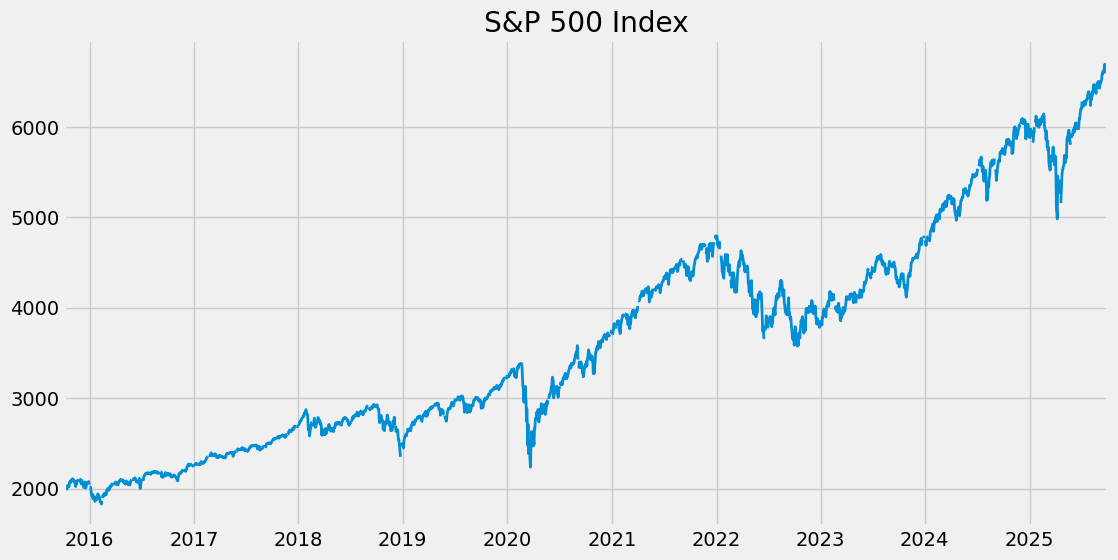

In [1]:
# python3 -m pip install plotly
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time


plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 500)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

#python3 -m pip install fredapi
from fredapi import Fred

fred_key = 'bc6d8c0c45fc715c318047ee73a41c1b'

#Create the Fred Object
fred = Fred(api_key=fred_key)

#Search for economic data 
sp_search = fred.search('S&P', order_by='popularity')

sp_search.head()

#Pulll raw data 
sp500 = fred.get_series(series_id='SP500')

sp500.plot(figsize=(12, 6), title='S&P 500 Index', lw=2, color=color_pal[0])


In [2]:
#Pull and Joy Multiple Data Series 
# only show those with specify conditions using filter 
unemp_df =  fred.search('unemployment rate state', filter=('frequency', 'Monthly'))
# now only show the columns we need. 
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
#Locating the unemployment rate series
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]   


In [3]:
# Go through the index or ID and pull each series


all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)


#Concatenate all the results into a single DataFrame
uemp_results = pd.concat(all_results, axis=1)

cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

uemp_states = uemp_results.copy() 
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

# Plotting the unemployment rate for each state
px.line(uemp_states)


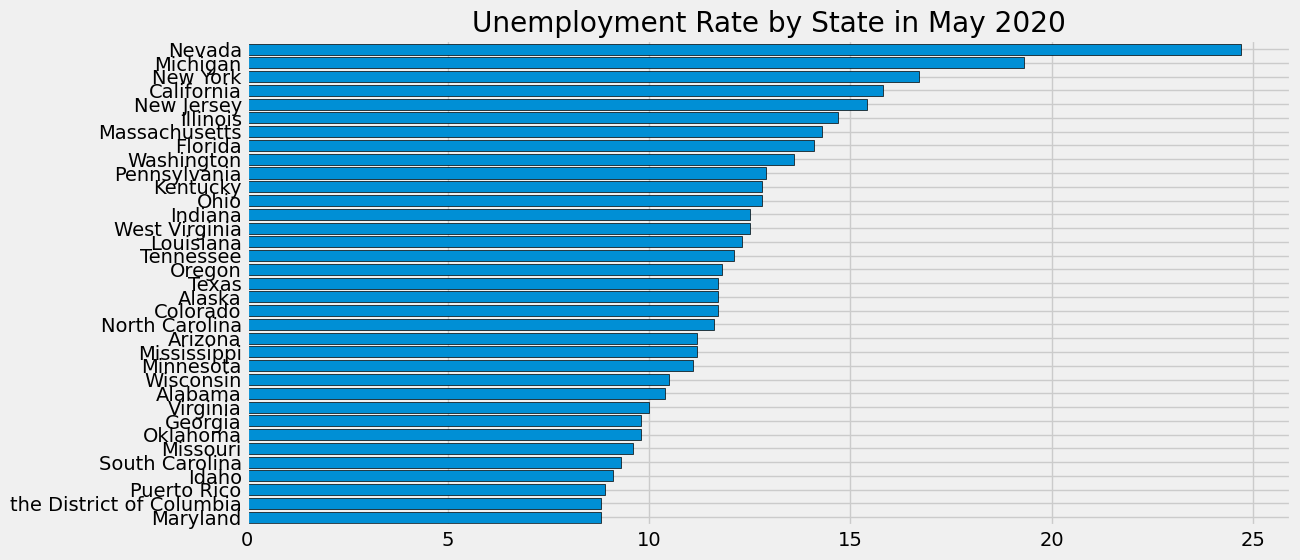

In [4]:
# Pull May 2020 Unemployment rate per states
ax = uemp_states.loc[pd.Timestamp('2020-05-01 ')] \
    .sort_values() \
    .plot(kind='barh' , figsize=(12,6), width = 0.8, edgecolor = 'black',title='Unemployment Rate by State in May 2020')

# ax.legend()
# plt.show()


In [5]:
#Pull Participation Rate
# Query is required to futher refine the search results as API filter can’t handle multiple fields in one go.

part_df = fred.search('participation rate state', filter=('frequency', 'Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')


part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]


In [6]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

IndexError: index 30 is out of bounds for axis 0 with size 30

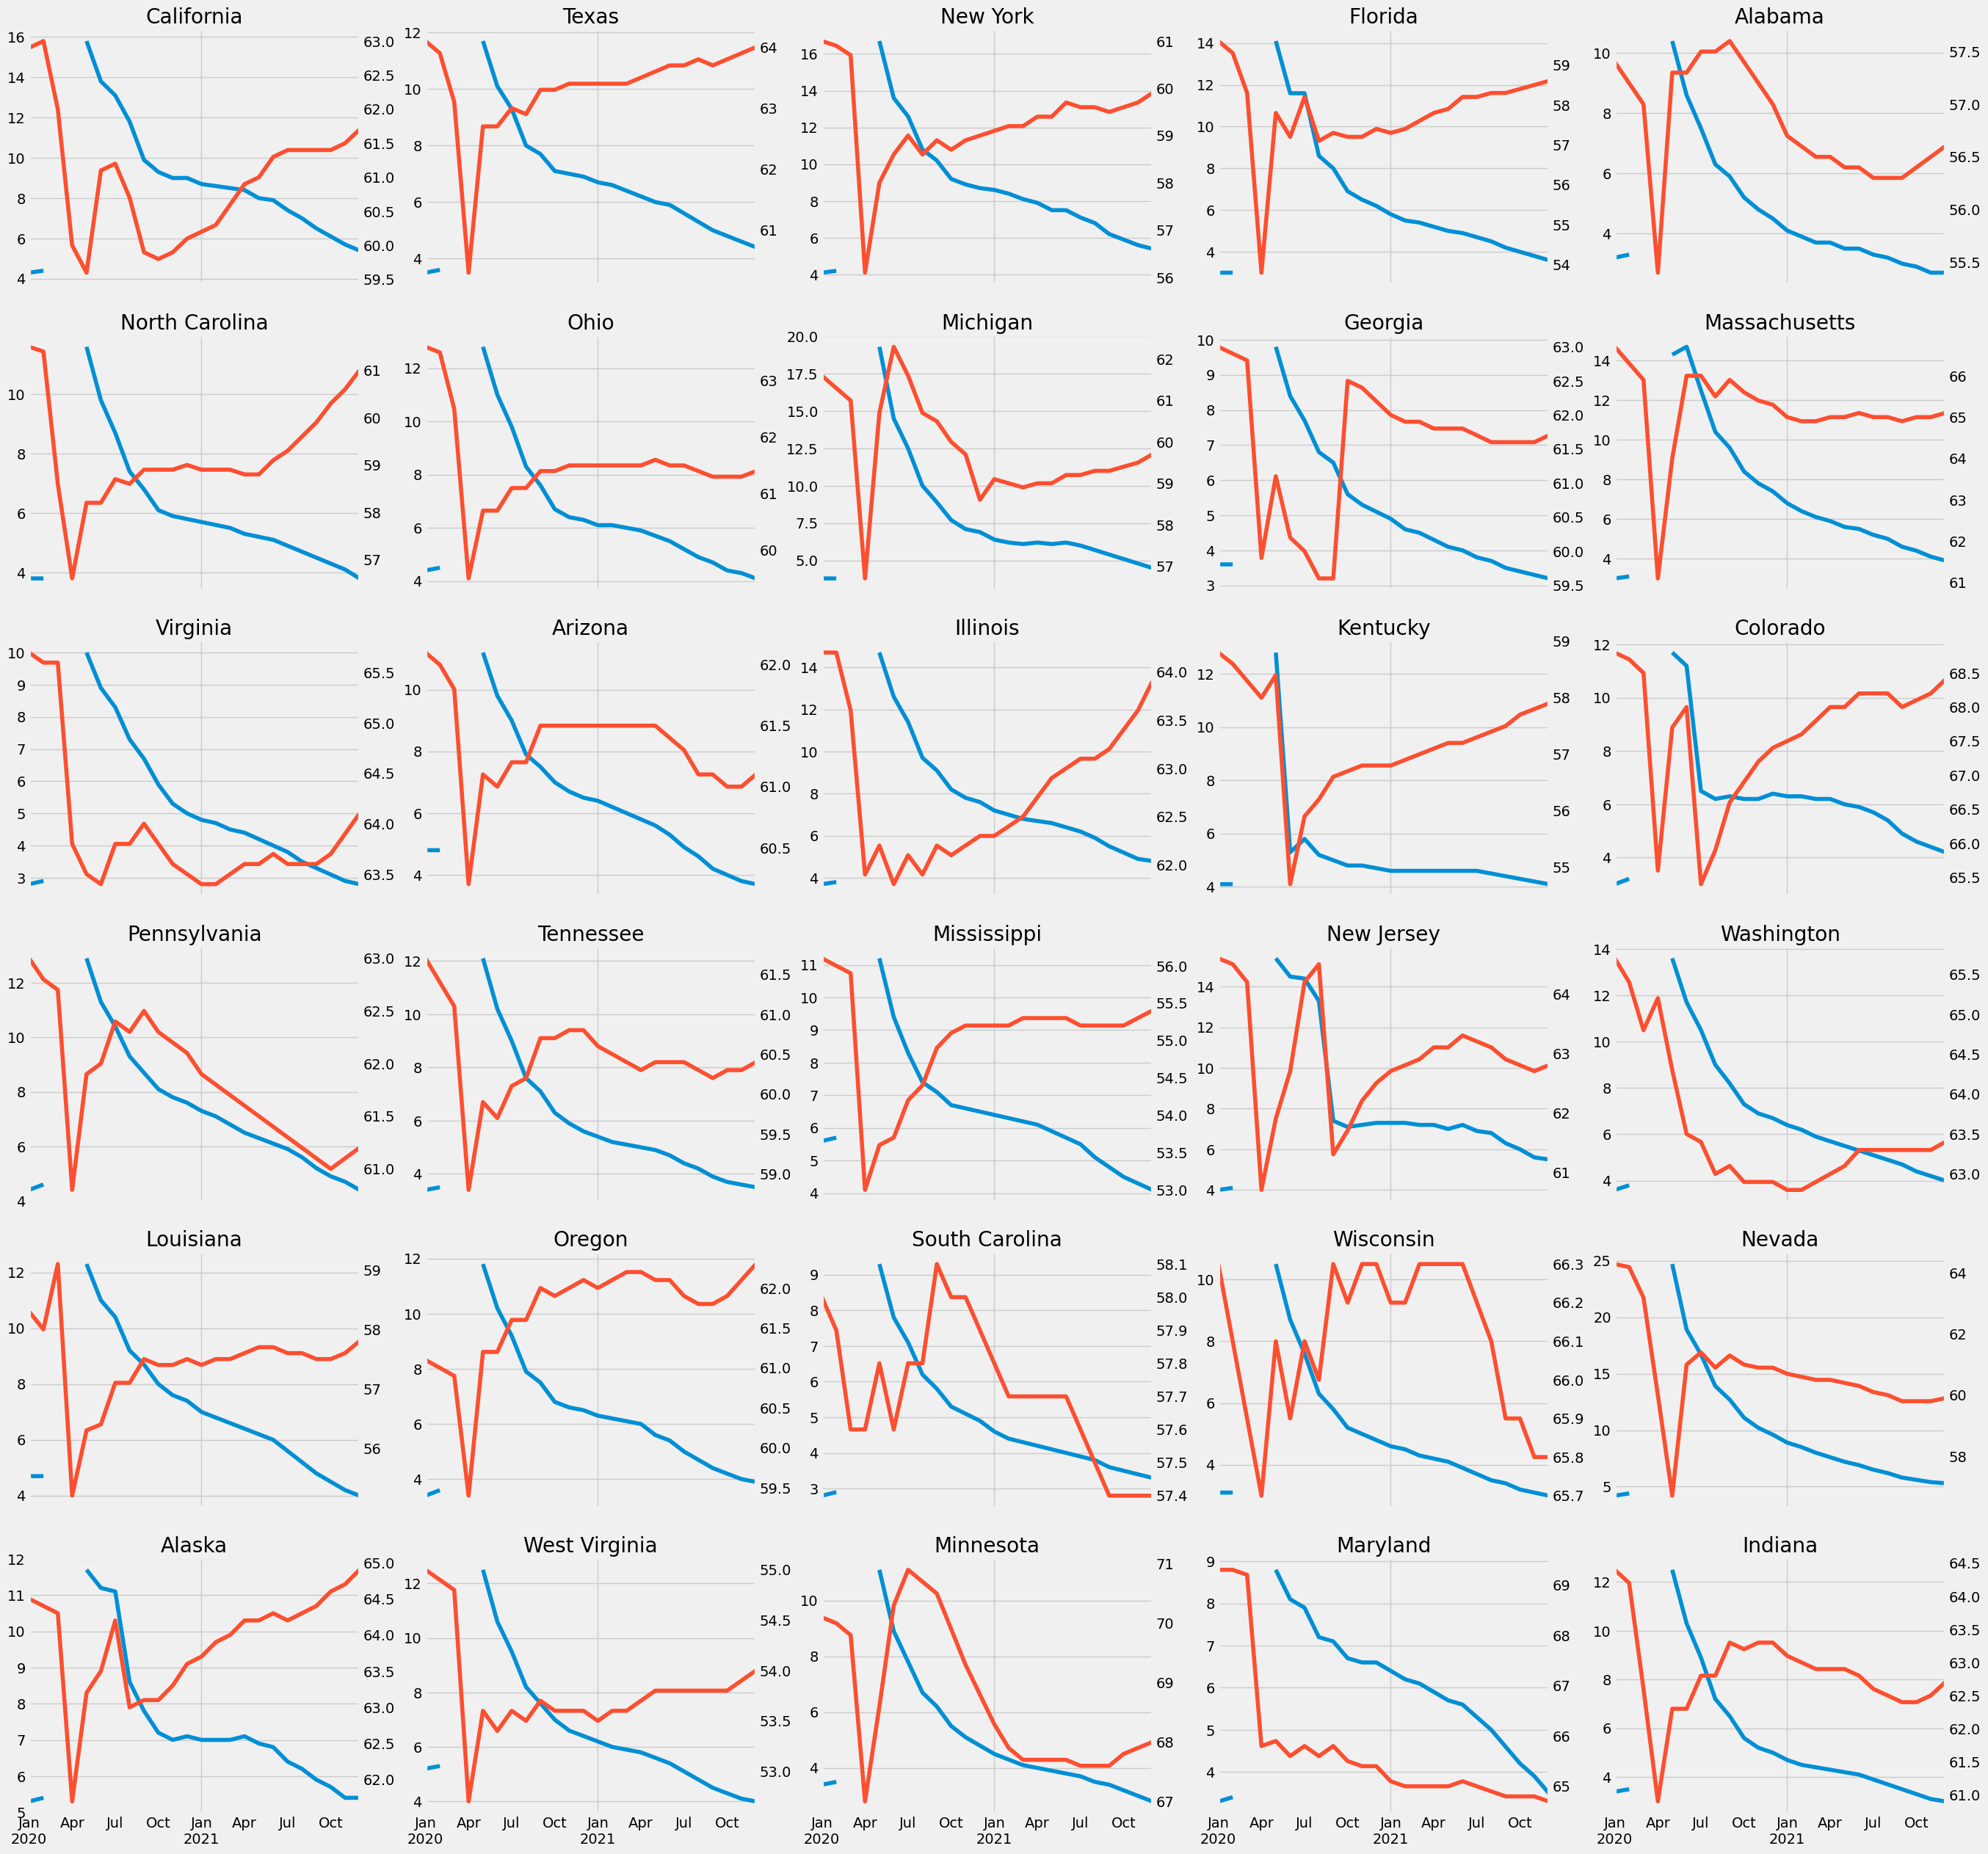

In [7]:
# Plot the participation rate vs unemployment rate
# ax=ax for when you want to plot multiple series on the same axes.
from matplotlib.lines import Line2D

fig, axs = plt.subplots(6, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()
uemp_states = uemp_states.asfreq('MS')

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()  # Create a second y-axis for the participation rate
    uemp_states.query('index >= 2020 and index < 2022')[state].plot(ax=axs[i], label = 'Unemployment Rate')
    part_states.query('index >= 2020 and index < 2022')[state].plot(ax=ax2, label = 'Participation Rate', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
# Create one legend for the whole figure
# Use the first subplot's lines for the legend
fig.legend(labels=['Unemployment','Participation'])
fig.legend(handles=[Line2D([0],[0], color=color_pal[0], label='Unemployment'),Line2D([0],[0], color = color_pal[1], label='Participation') ],loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()




In [ ]:
state = 'New York'
fig, ax = plt.subplots(figsize=(10, 5), sharex=True) 
ax2 = ax.twinx()  # Create a second y-axis for the participation rate
uemp_states2 = uemp_states.asfreq('MS')

# Plot unemployment rate only
uemp_states2.query('index >= 2020 and index < 2022')[state].plot(ax=ax, label = 'Unemployment Rate')
part_states.query('index >= 2020 and index < 2022')[state].plot(ax=ax2, label = 'Participation Rate', color=color_pal[1])

ax2.grid(False)
ax.set_title(state)
fig.legend(labels=['Unemployment','Participation'])
plt.show()
